# FINAL PROJECT: E-Commerce Product Price Prediction

José Pérez & Telmo Linacisoro

## 0) LOADING & UNDERSTANDING DATASET

In [13]:
import os
import seaborn as sns
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import lightgbm as lgb
import shap
import pickle
pd.set_option('display.max_columns', None)

In [14]:
# LOAD DATASET
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/Analítica Visual/Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# MERGE DE CSVS
olist_orders_dataset = pd.read_csv(data_path + 'olist_orders_dataset.csv')
olist_order_payments_dataset = pd.read_csv(data_path + 'olist_order_payments_dataset.csv')
olist_order_reviews_dataset = pd.read_csv(data_path + 'olist_order_reviews_dataset.csv')
olist_customers_dataset = pd.read_csv(data_path + 'olist_customers_dataset.csv')
olist_order_items_dataset = pd.read_csv(data_path + 'olist_order_items_dataset.csv')
olist_products_dataset = pd.read_csv(data_path + 'olist_products_dataset.csv')
olist_sellers_dataset = pd.read_csv(data_path + 'olist_sellers_dataset.csv')

# Step 1: Merge orders with payments
source = olist_orders_dataset.merge(
    olist_order_payments_dataset,
    on='order_id',
    how='left'
)

# Step 2: Merge with reviews
merged_queries = source.merge(
    olist_order_reviews_dataset,
    on='order_id',
    how='left'
)

# Step 3: Merge with customers (Left join)
merged_queries1 = merged_queries.merge(
    olist_customers_dataset,
    on='customer_id',
    how='left'
)

# Step 4: Merge with order items (Left join)
merged_queries2 = merged_queries1.merge(
    olist_order_items_dataset,
    on='order_id',
    how='left'
)

# Step 5: Merge with products (Left join)
merged_queries3 = merged_queries2.merge(
    olist_products_dataset,
    on='product_id',
    how='left'
)

# Step 6: Merge with sellers (Left join)
final_result = merged_queries3.merge(
    olist_sellers_dataset,
    on='seller_id',
    how='left'
)

# Save or use the resulting DataFrame
final_result.to_csv(data_path + 'master_dataset.csv', index=False) # it may take 5-10 seconds to save

In [16]:
df = pd.read_csv(data_path + 'master_dataset.csv')

**Diagram of the Construction of the DataFrame from Individual CSV Files**

The data was obtained by merging individual CSV files, as described in the following diagram.


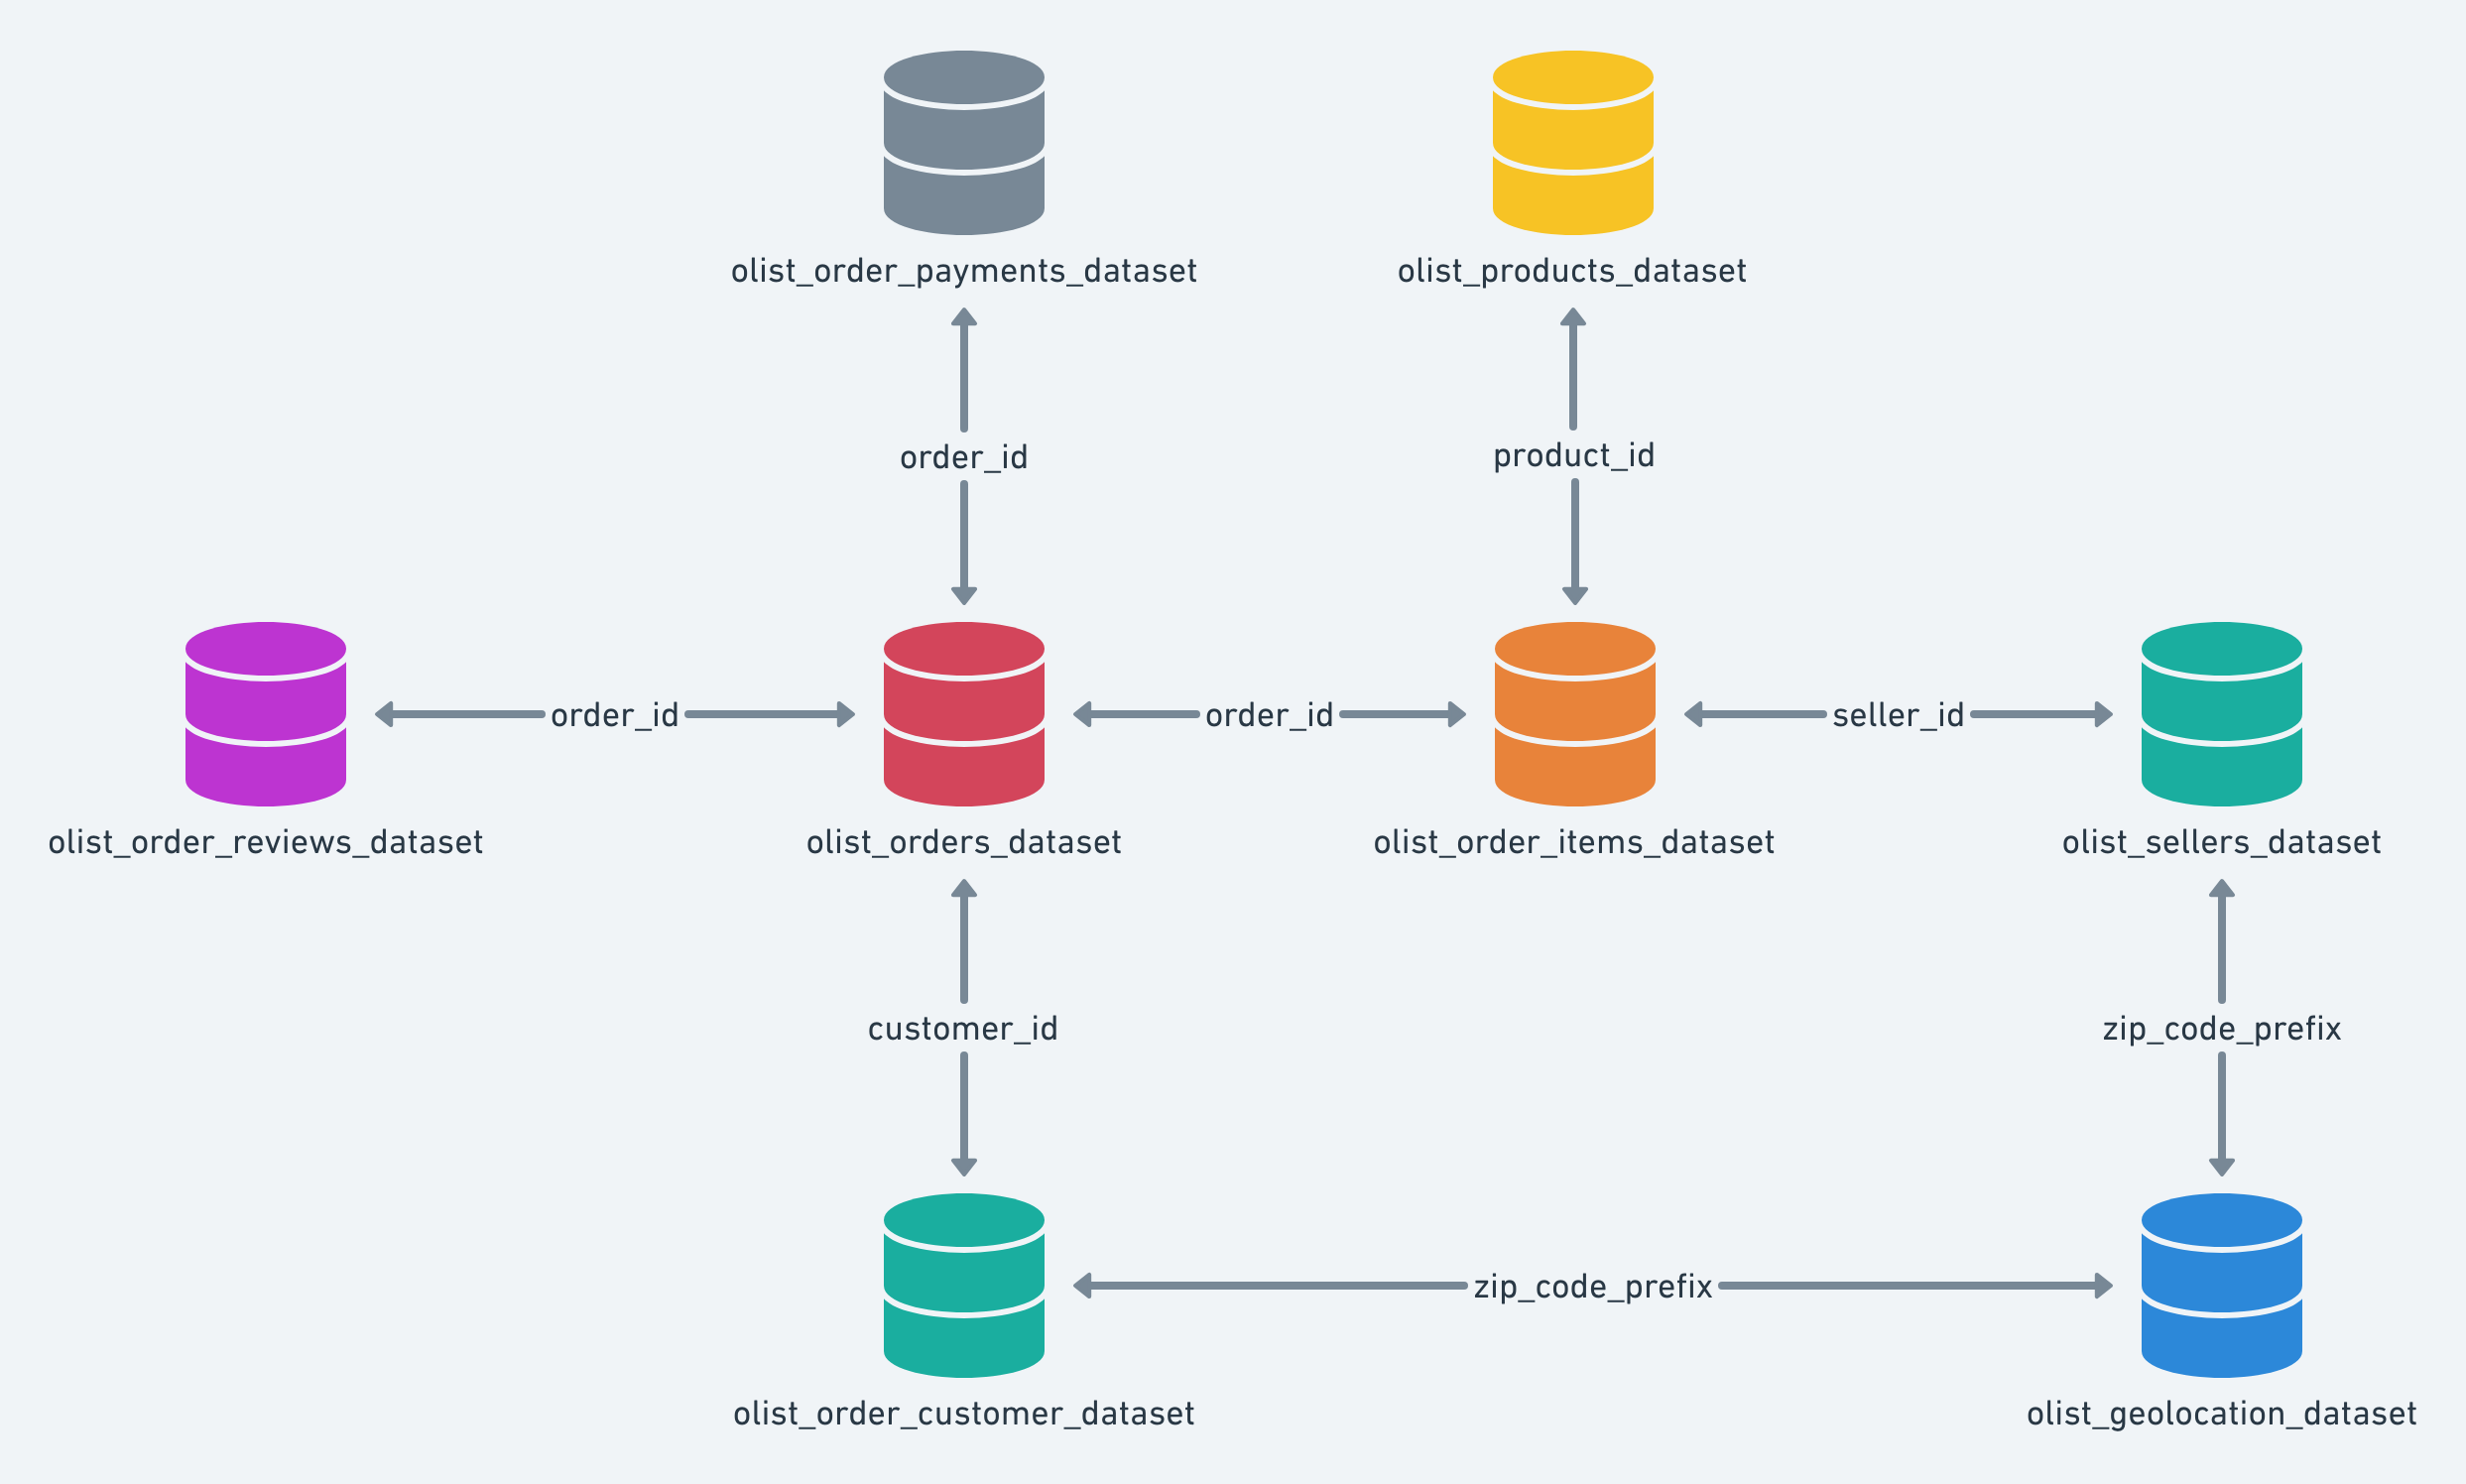

Summary of columns:

1. **`order_id`**: Unique identifier for each order.  
2. **`customer_id`**: Identifier for the customer placing the order.  
3. **`order_status`**: Status of the order.  
4. **`order_purchase_timestamp`**: Timestamp when the order was placed.  
5. **`order_approved_at`**: Timestamp when the payment for the order was approved.  
6. **`order_delivered_carrier_date`**: Date when the order was handed over to the carrier for delivery.  
7. **`order_delivered_customer_date`**: Date when the order was delivered to the customer.  
8. **`order_estimated_delivery_date`**: Estimated delivery date provided to the customer.  
9. **`payment_sequential`**: Sequential number indicating the payment order (useful for multiple payments per order).  
10. **`payment_type`**: Type of payment used (e.g., credit card, boleto, voucher).  
11. **`payment_installments`**: Number of payment installments chosen.  
12. **`payment_value`**: Total amount paid for the payment sequential.  
13. **`review_id`**: Unique identifier for the review associated with the order.  
14. **`review_score`**: Score given in the review (e.g., 1 to 5 stars).  
15. **`review_comment_title`**: Title of the review comment.  
16. **`review_comment_message`**: Detailed comment provided in the review.  
17. **`review_creation_date`**: Date when the review was created.  
18. **`review_answer_timestamp`**: Timestamp when the review was answered by the seller or platform.  
19. **`customer_unique_id`**: Unique identifier for each customer (across orders).  
20. **`customer_zip_code_prefix`**: First five digits of the customer's zip code.  
21. **`customer_city`**: City of the customer.  
22. **`customer_state`**: State of the customer.  
23. **`order_item_id`**: Sequential number for items within the order.  
24. **`product_id`**: Unique identifier for the product.  
25. **`seller_id`**: Unique identifier for the seller.  
26. **`shipping_limit_date`**: Deadline for the seller to ship the product.  
27. **`price`**: Price of the product in the order.  
28. **`freight_value`**: Freight cost charged for shipping the product.  
29. **`product_category_name`**: Category of the product (e.g., electronics, books).  
30. **`product_name_lenght`**: Length of the product name (number of characters).  
31. **`product_description_lenght`**: Length of the product description (number of characters).  
32. **`product_photos_qty`**: Number of photos available for the product.  
33. **`product_weight_g`**: Weight of the product in grams.  
34. **`product_length_cm`**: Length of the product in centimeters.  
35. **`product_height_cm`**: Height of the product in centimeters.  
36. **`product_width_cm`**: Width of the product in centimeters.  
37. **`seller_zip_code_prefix`**: First five digits of the seller's zip code.  
38. **`seller_city`**: City of the seller.  
39. **`seller_state`**: State of the seller.  


In [17]:
# SELECT NECESSARY COLUMNS FOR PRICE PREDICTION
necessary_columns = [
    'price',
    'product_category_name',
    'product_name_lenght',
    'product_description_lenght',
    'product_photos_qty',
    'freight_value',
    'order_status',
    'customer_zip_code_prefix',
    'seller_zip_code_prefix',
    'seller_city',
    'seller_state',
    'payment_type',
    'payment_installments',
    'order_purchase_timestamp',
    'order_delivered_customer_date',
    'review_score',
    'customer_city',
    'customer_state',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm',
    'shipping_limit_date'
]

df = df[necessary_columns]

Disregarded Columns in the price prediction model:

1. **`order_id`**:  
   - **Reason**: It is a unique identifier for each order and does not provide meaningful information related to the price.

2. **`customer_id`**:  
   - **Reason**: While important for customer segmentation, it is not directly relevant to predicting the price of an order.

3. **`order_approved_at`**:  
   - **Reason**: This timestamp is primarily related to payment confirmation and is not directly tied to the price prediction.

4. **`order_delivered_carrier_date`**:  
   - **Reason**: This is a logistic timestamp and doesn't influence the price directly.

5. **`order_estimated_delivery_date`**:  
   - **Reason**: This is an estimated date for delivery, which is not directly tied to the price of the product.

6. **`payment_sequential`**:  
   - **Reason**: Sequential number for the payment does not provide direct insight into price prediction, especially if multiple payments are involved.

7. **`review_id`**:  
   - **Reason**: Unique identifier for the review, which doesn't help in predicting price. The review score might be more useful.

8. **`review_comment_title`**:  
   - **Reason**: The title of the review doesn't contribute to price prediction as it doesn't provide information about the price itself.

9. **`review_comment_message`**:  
   - **Reason**: The detailed review comment could be informative about customer experience but is not directly related to the product's price.

10. **`review_creation_date`**:  
    - **Reason**: The date of the review doesn't directly affect the price prediction.

11. **`review_answer_timestamp`**:  
    - **Reason**: This timestamp indicates when the seller responded to the review, but it doesn't directly affect the price.

Note: Additionally, reviews are extremely sparse. They lead to more errors than actual benefits to the model down the line. Moreover, sellers who may want to use the tool to select the correct pricing for their product most likely won't have any reviews available.

12. **`customer_unique_id`**:  
    - **Reason**: While unique, it’s not directly related to the pricing model, as we’re more focused on the product and order characteristics.

13. **`order_item_id`**:  
    - **Reason**: This is a sequential number for items within the order, and may not add meaningful value for price prediction, especially if there are multiple items per order.

14. **`product_id`**:  
    - **Reason**: While important, it is assumed that `product_category_name` will already account for product-related features, so `product_id` is considered redundant.

15. **`seller_id`**:  
    - **Reason**: This is a unique identifier for the seller and doesn't provide direct information for predicting the price.

16. **`shipping_limit_date`**:  
    - **Reason**: Although related to logistics, the shipping limit date doesn't impact the price directly unless it's tied to urgency or surcharge, which isn’t specified.

The selection focuses on columns that are likely to influence the price directly, such as product characteristics, payment methods and review scores. Other logistical and identifying details, while important in other contexts, aren't considered relevant for price prediction.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   price                          118310 non-null  float64
 1   product_category_name          116601 non-null  object 
 2   product_name_lenght            116601 non-null  float64
 3   product_description_lenght     116601 non-null  float64
 4   product_photos_qty             116601 non-null  float64
 5   freight_value                  118310 non-null  float64
 6   order_status                   119143 non-null  object 
 7   customer_zip_code_prefix       119143 non-null  int64  
 8   seller_zip_code_prefix         118310 non-null  float64
 9   seller_city                    118310 non-null  object 
 10  seller_state                   118310 non-null  object 
 11  payment_type                   119140 non-null  object 
 12  payment_installments          

## 1) PREPROCESSING DATASET

In [19]:
df = df.dropna() #remove rows with some null value

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format="%Y-%m-%d %H:%M:%S")
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'], format="%Y-%m-%d %H:%M:%S")
df['order_duration'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'], format="%Y-%m-%d %H:%M:%S")
df['delivery_duration'] = (df['shipping_limit_date'] - df['order_purchase_timestamp']).dt.days

df = df.drop(columns=['order_purchase_timestamp', 'order_delivered_customer_date','shipping_limit_date']) # Drop the original timestamp columns

df = df.drop_duplicates() # remove duplicate rows

categorical_variables = [ 'product_category_name', 'order_status','seller_city', 'seller_state', 'payment_type', 'customer_city','customer_state']

numerical_variables = ['price','product_name_lenght','product_description_lenght','product_photos_qty','freight_value','customer_zip_code_prefix',
                       'seller_zip_code_prefix','payment_installments', 'review_score','product_weight_g','product_length_cm','product_height_cm',
                        'product_width_cm','order_duration','delivery_duration']

# Remove outliers
for col in numerical_variables:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

#Create an encoded dataset with all categorical columns encoded
df_encoded = df.copy()
encoders = {} #empty dictionary
for column in categorical_variables:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df[column])
    encoders[column] = le  # Store the encoder for the column in the dictionary -> dictionary 'encoders' contains the encoders for each column

<ipython-input-19-ec94c5417680>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format="%Y-%m-%d %H:%M:%S")


In [20]:
df.to_csv(data_path + 'df_notencoded.csv', index=False)
df_encoded.to_csv(data_path + 'df_encoded.csv', index=False)

## 2) EXPLORATORY DATA ANALYSIS (essentials; further developed in Streamlit)

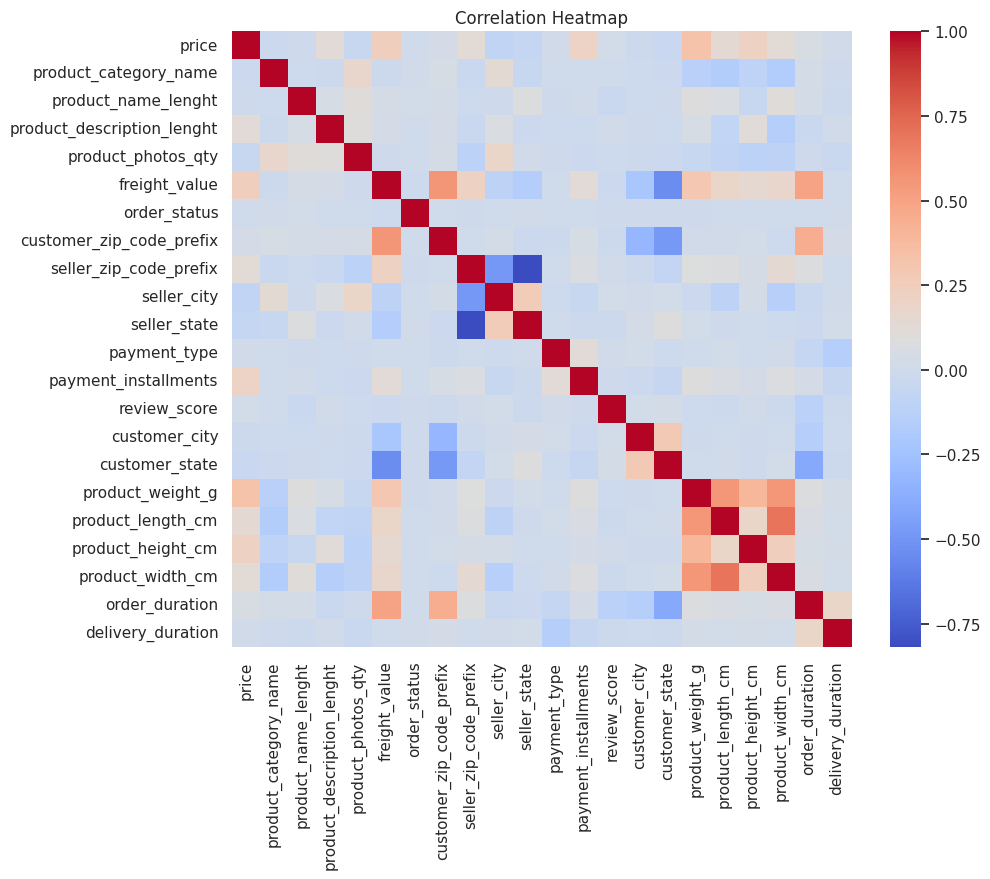

In [27]:
# correlation plot
sns.set(style="whitegrid")
corr = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

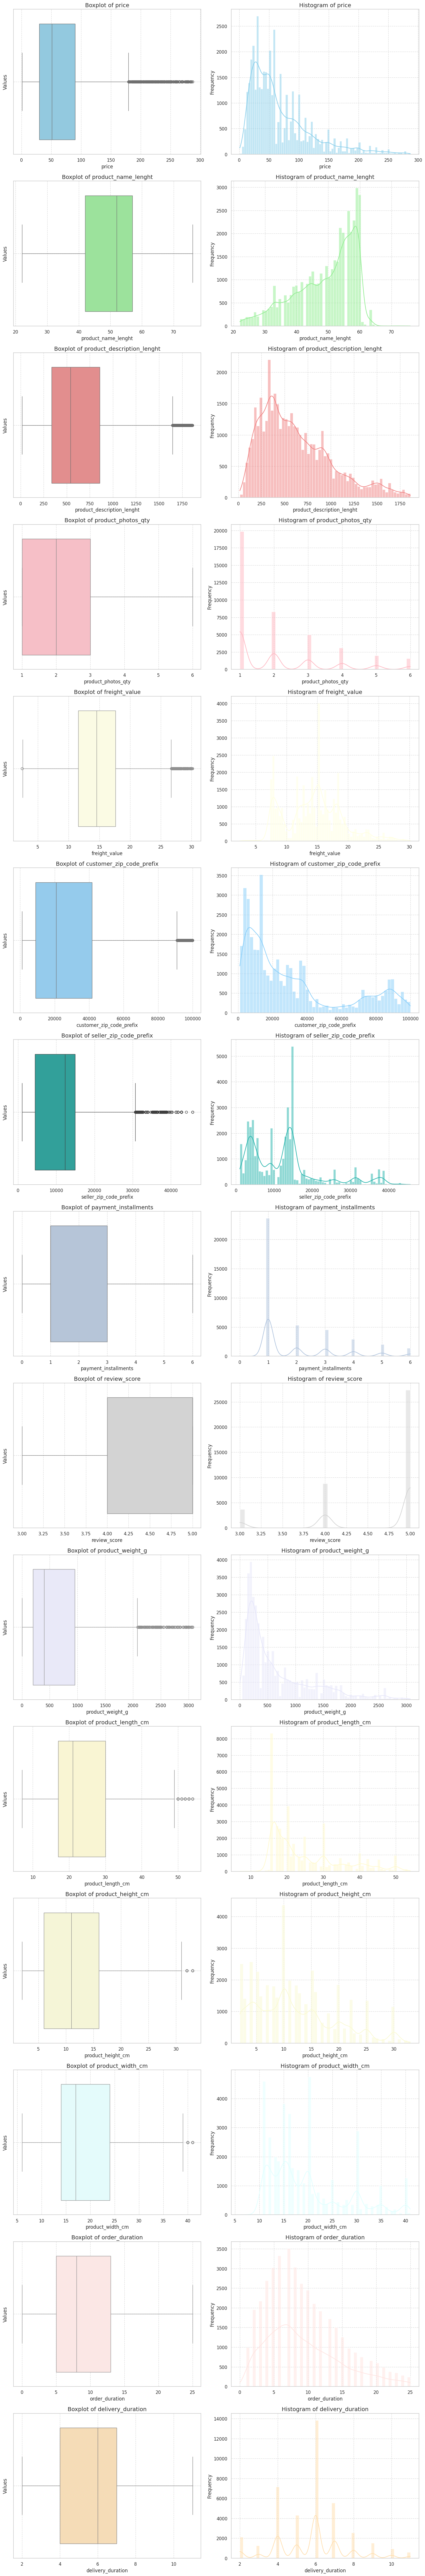

In [28]:
# Set a style for better visuals
sns.set(style="whitegrid")
colors = [
    'skyblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow', 'lightskyblue',
    'lightseagreen', 'lightsteelblue', 'lightgray', 'lavender', 'lemonchiffon', 'lightgoldenrodyellow',
    'lightcyan', 'mistyrose', 'navajowhite', 'peachpuff', 'powderblue', 'rosybrown', 'seashell',
    'mediumturquoise', 'mediumslateblue', 'mediumorchid', 'palevioletred', 'wheat', 'yellowgreen',
    'springgreen', 'paleturquoise', 'cornflowerblue', 'indianred', 'cadetblue', 'tomato'
]
num_plots = 2*len(numerical_variables)
cols = 2  # Two columns: one for boxplot, one for histogram
rows = len(numerical_variables)

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
axes = axes.flatten()

for i, column in enumerate(numerical_variables):
    # Plot Boxplot
    sns.boxplot(data=df, x=column, ax=axes[2 * i], color=colors[i % len(colors)])
    axes[2 * i].set_title(f'Boxplot of {column}', fontsize=14)
    axes[2 * i].set_xlabel(column, fontsize=12)
    axes[2 * i].set_ylabel('Values', fontsize=12)
    axes[2 * i].grid(True, linestyle='--', alpha=0.7)

    # Plot Histogram
    sns.histplot(df[column], kde=True, color=colors[i % len(colors)], ax=axes[2 * i + 1])
    axes[2 * i + 1].set_title(f'Histogram of {column}', fontsize=14)
    axes[2 * i + 1].set_xlabel(column, fontsize=12)
    axes[2 * i + 1].set_ylabel('Frequency', fontsize=12)
    axes[2 * i + 1].grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

## 3) MODEL TRAINING AND TESTING

### 3.1) Price Prediction Tool

In [29]:
y = df_encoded['price']
X = df_encoded.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [30]:
"""
param_grid = {
    'n_estimators': [600, 650],
    'max_depth': [13, 14],
    'learning_rate': [0.1],
    'num_leaves': [250, 300],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'min_child_samples': [20, 30],
}


grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'num_leaves': 250, 'n_estimators': 600, 'min_child_samples': 20, 'max_depth': 13, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best Score: 0.814922414450761
"""

# Define the model with the best parameters
lgbm_price = lgb.LGBMRegressor(
    subsample=0.8,
    reg_lambda=1,
    reg_alpha=1,
    num_leaves=250,
    n_estimators=600,
    min_child_samples=20,
    max_depth=13,
    learning_rate=0.1,
    colsample_bytree=0.7,
    random_state=21  # For reproducibility
)

lgbm_price.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 31888, number of used features: 20
[LightGBM] [Info] Start training from score 67.940644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMRegressor(colsample_bytree=0.7, max_depth=13, n_estimators=600,
              num_leaves=250, random_state=21, reg_alpha=1, reg_lambda=1,
              subsample=0.8)

Test RMSE: 21.94
Test MAE: 12.77
Test R²: 0.81


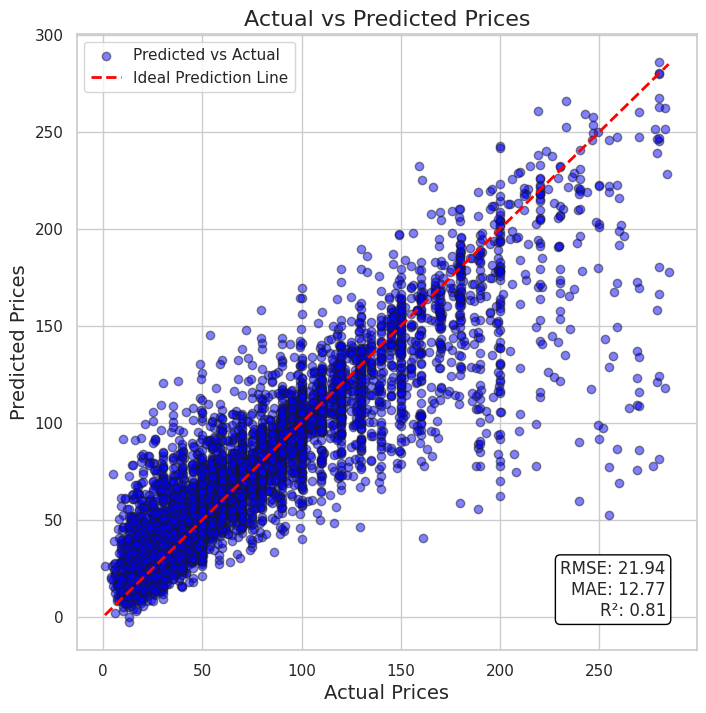

In [31]:
y_pred = lgbm_price.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.2f}")

# Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k', color='blue', label='Predicted vs Actual')
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color='red',
    linestyle='--',
    linewidth=2,
    label='Ideal Prediction Line',
)
plt.title('Actual vs Predicted Prices', fontsize=16)
plt.xlabel('Actual Prices', fontsize=14)
plt.ylabel('Predicted Prices', fontsize=14)
plt.legend()
plt.grid(True)

# Annotate Metrics on the Plot
metrics_text = f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.2f}"
plt.gca().text(
    0.95,
    0.05,
    metrics_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle="round", facecolor="white", edgecolor="black"),
)

plt.show()

### 3.2) Trend Analysis Tool

In [32]:
df_trends = df_encoded.copy()
df_trends[df_trends['order_status'] == 1]

groupby = df_trends.groupby('product_category_name').agg({
    'order_status': 'sum',
    'review_score': ['mean', 'std']
}).reset_index()

groupby.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in groupby.columns]

df_trends = df_trends.merge(groupby, on='product_category_name', how='left')
df_trends = df_trends.dropna()
y_trends = df_trends['order_status_sum']
X_trends = df_trends.drop(columns=['order_status_sum'])
X_train_trends, X_test_trends, y_train_trends, y_test_trends = train_test_split(X_trends, y_trends, test_size=0.2, random_state=21)

lgbm_trends = lgb.LGBMRegressor(random_state=21)
lgbm_trends.fit(X_train_trends, y_train_trends)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 31886, number of used features: 23
[LightGBM] [Info] Start training from score 2235.751113


LGBMRegressor(random_state=21)

Test RMSE: 1.05
Test MAE: 0.14
Test R²: 1.00


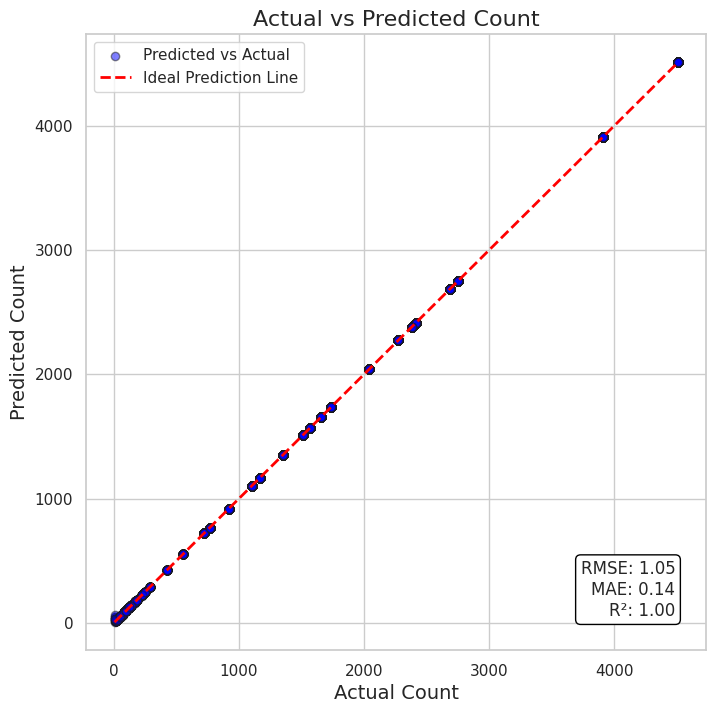

In [33]:
y_pred_trends = lgbm_trends.predict(X_test_trends)

# Metrics Calculation
rmse_trends = np.sqrt(mean_squared_error(y_test_trends, y_pred_trends))
mae_trends = mean_absolute_error(y_test_trends, y_pred_trends)
r2_trends = r2_score(y_test_trends, y_pred_trends)

# Print Metrics
print(f"Test RMSE: {rmse_trends:.2f}")
print(f"Test MAE: {mae_trends:.2f}")
print(f"Test R²: {r2_trends:.2f}")

# Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_trends, y_pred_trends, alpha=0.5, edgecolor='k', color='blue', label='Predicted vs Actual')
plt.plot(
    [min(y_test_trends), max(y_test_trends)],
    [min(y_test_trends), max(y_test_trends)],
    color='red',
    linestyle='--',
    linewidth=2,
    label='Ideal Prediction Line',
)
plt.title('Actual vs Predicted Count', fontsize=16)
plt.xlabel('Actual Count', fontsize=14)
plt.ylabel('Predicted Count', fontsize=14)
plt.legend()
plt.grid(True)

# Annotate Metrics on the Plot
metrics_text = f"RMSE: {rmse_trends:.2f}\nMAE: {mae_trends:.2f}\nR²: {r2_trends:.2f}"
plt.gca().text(
    0.95,
    0.05,
    metrics_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle="round", facecolor="white", edgecolor="black"),
)

plt.show()


## 4) MODEL EXPLAINABILITY

In [34]:
X_test_sample = X_test.sample(500, random_state=21)  # We do not need to explain the whole test dataset. 500 random samples should be more than enough.
shap.initjs()
explainer_price=shap.Explainer(lgbm_price)
shap_values_price = explainer_price(X_test_sample)
shap_values_price.shape # (n_samples, n_features) because there is only one output value. This differs from classification, where the shape would be (n_samples, n_features, n_classes).

(500, 21)

### 4.1) Global Explainability

In [35]:
# Global Force Plot
shap.initjs()
shap.plots.force(shap_values_price)

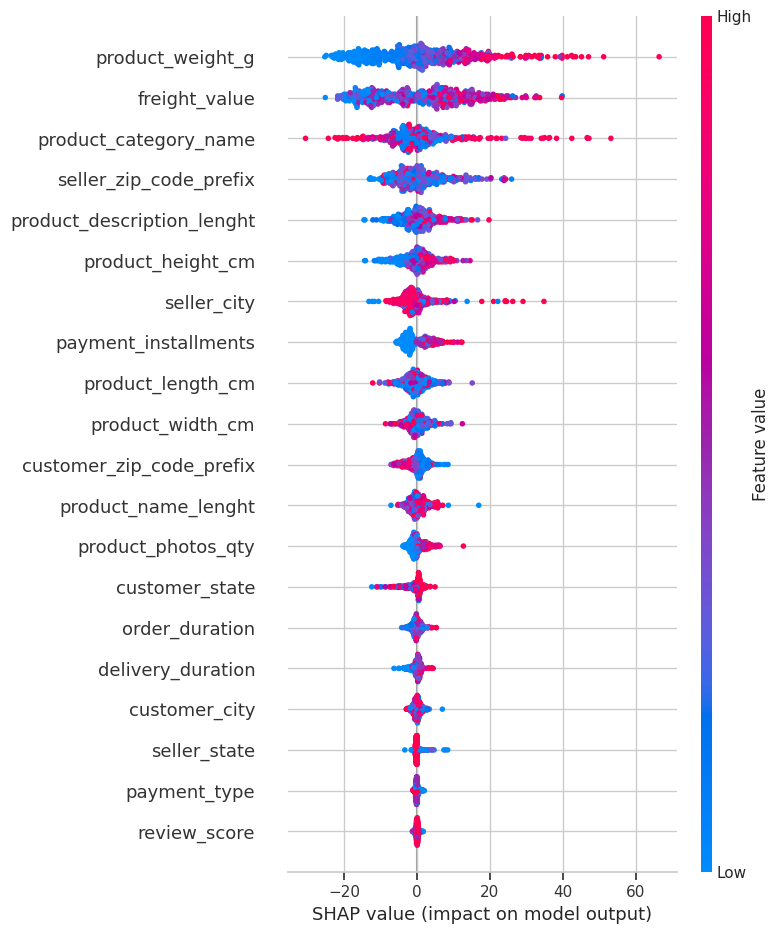

In [36]:
# Global Explainability Plots
shap.summary_plot(shap_values_price.values, X_test_sample)

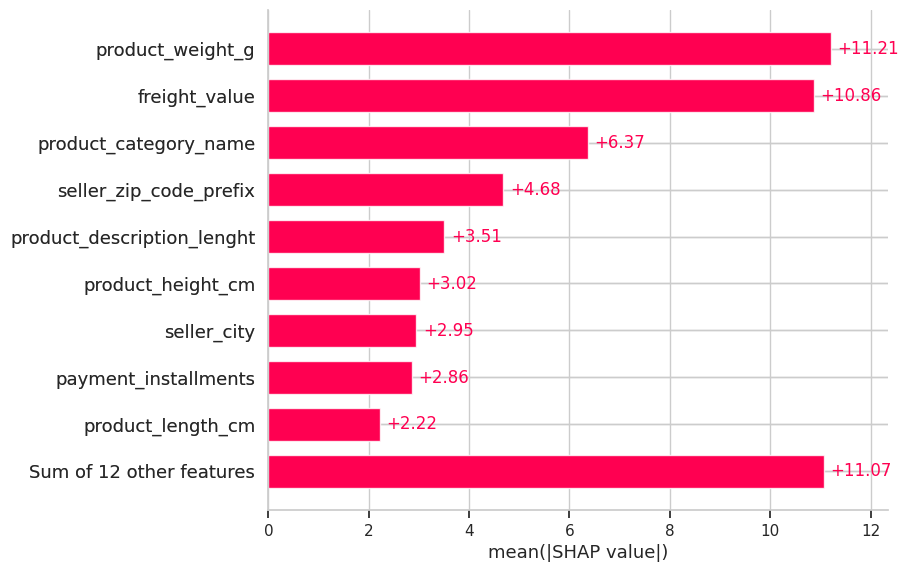

In [37]:
shap.plots.bar(shap_values_price, max_display=10)

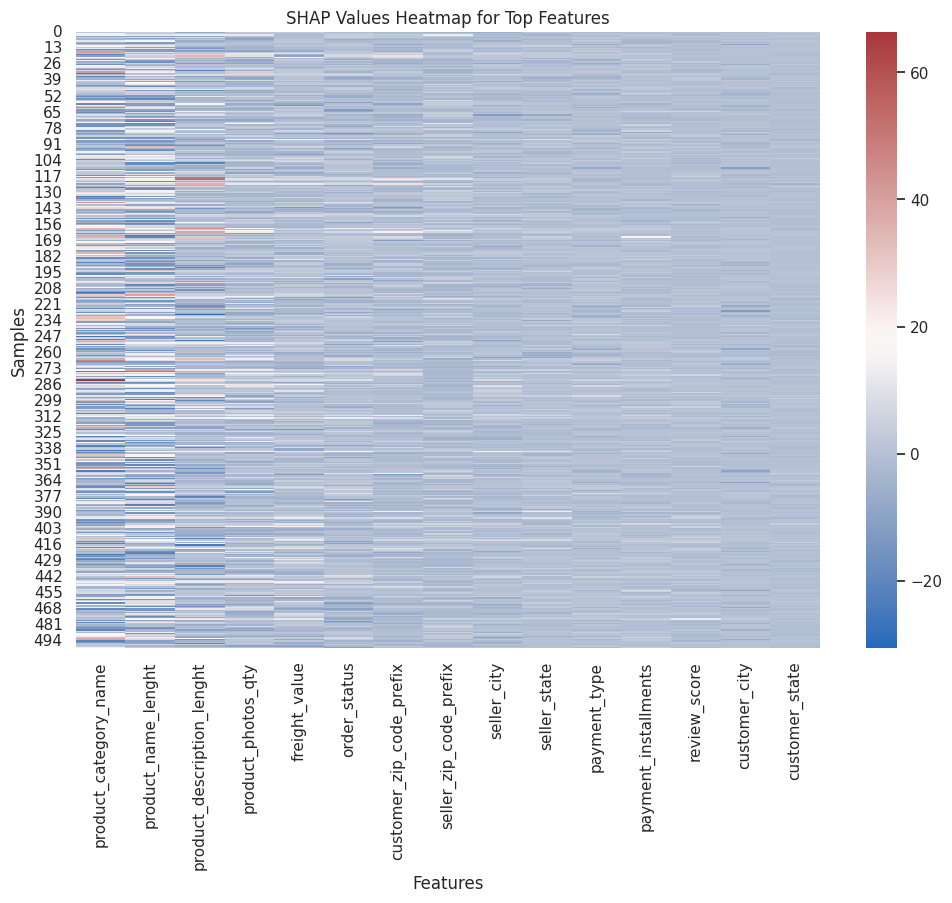

In [38]:
feature_names = X_test_sample.columns.tolist()
mean_abs_shap_values = np.abs(shap_values_price.values).mean(axis=0)
sorted_idx = np.argsort(mean_abs_shap_values)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

top_features = 15
sorted_features = feature_names[:top_features]
heatmap_data = pd.DataFrame(shap_values_price.values[:, sorted_idx[:top_features]],
                            columns=sorted_features)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="vlag", cbar=True)
plt.title("SHAP Values Heatmap for Top Features")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()
#Notice how the heatmap progressively gets lighter from left to right

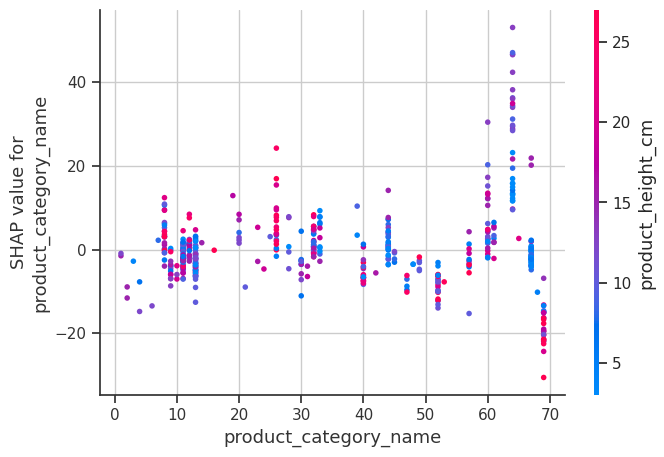

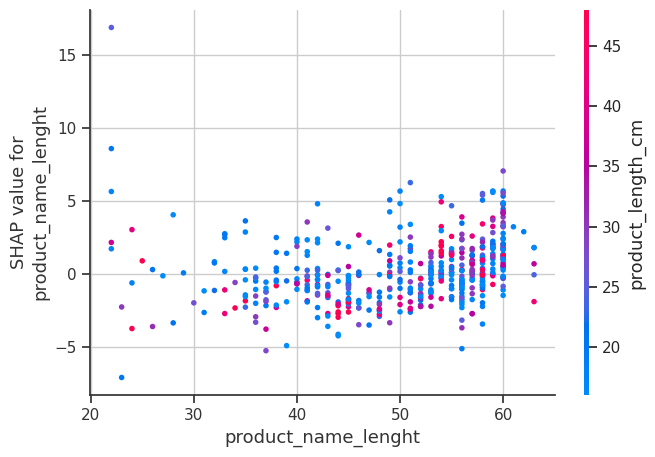

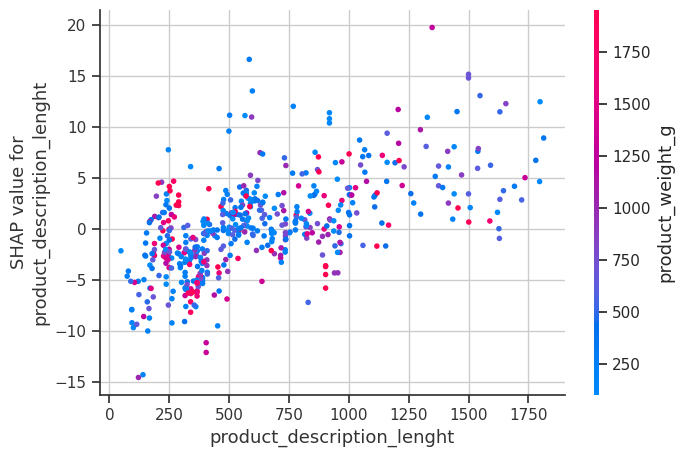

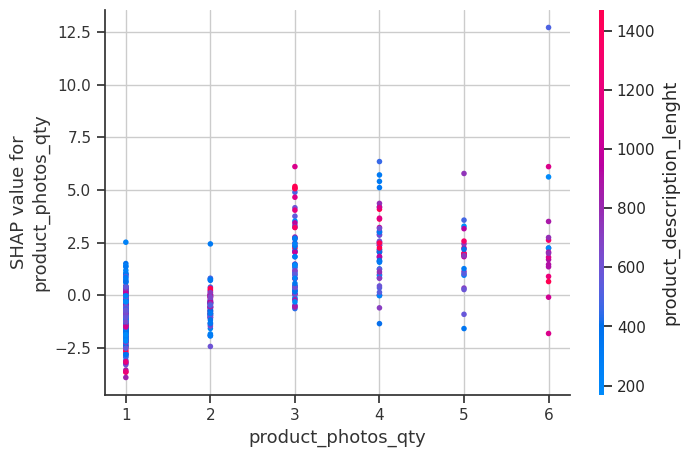

In [39]:
top_features = sorted_features[:4]
for i, feature in enumerate(top_features):
    shap.dependence_plot(feature, shap_values_price.values, X_test_sample, show=False)

### 4.2) Local Explainability

In [40]:
instance_idx = 23

In [41]:
# Local Force Plot
shap.initjs()
shap.plots.force(shap_values_price[instance_idx])

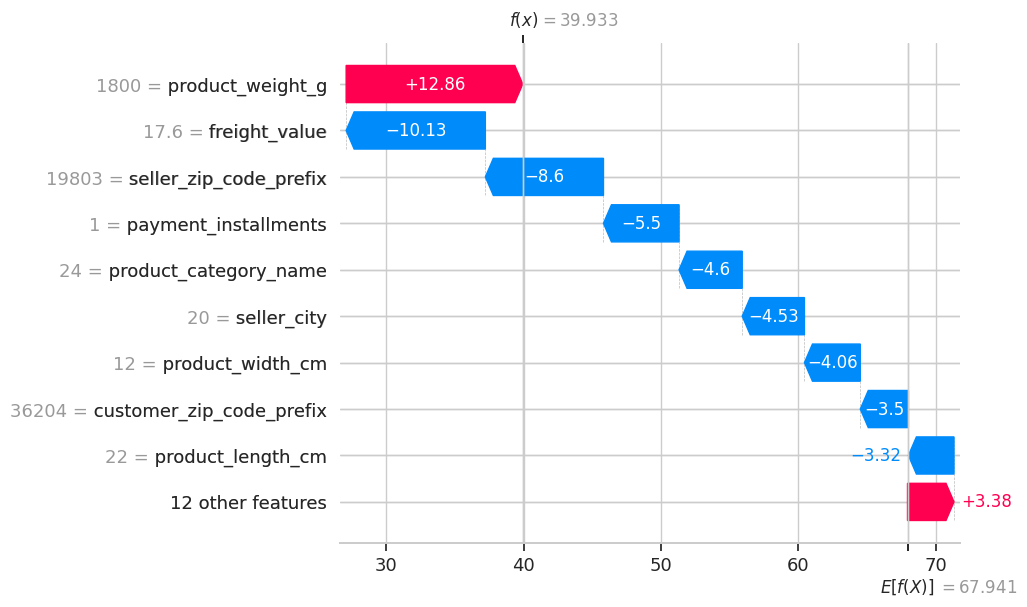

In [42]:
shap.plots.waterfall(shap_values_price[instance_idx])

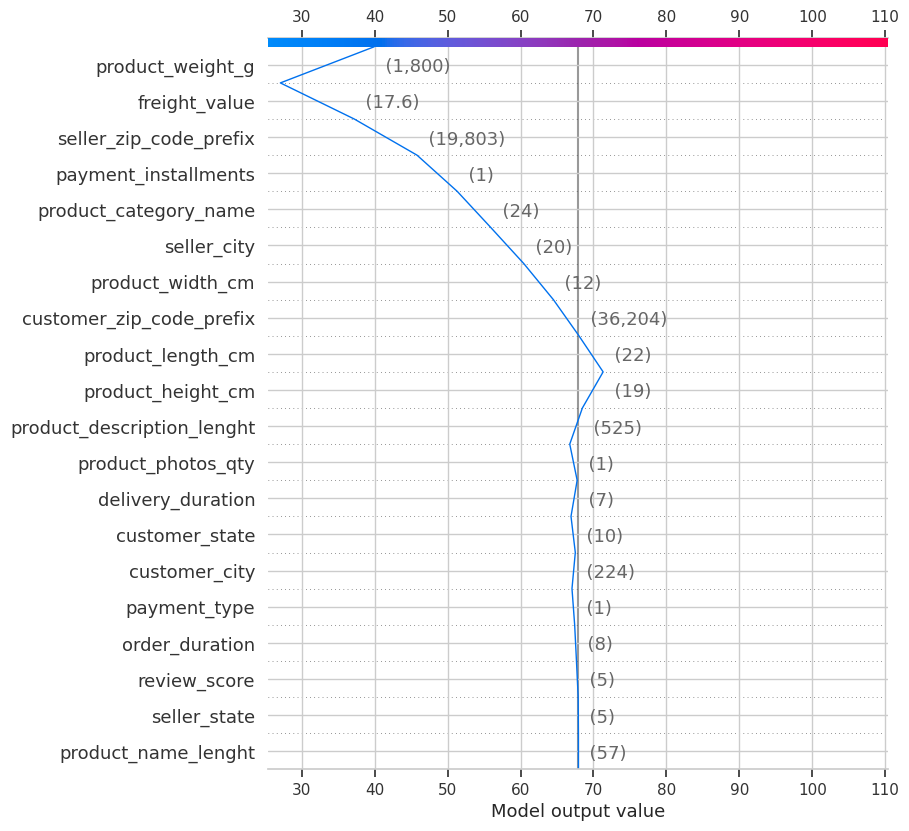

In [43]:
shap.decision_plot(shap_values_price.base_values[instance_idx],
                   shap_values_price.values[instance_idx],
                   X_test_sample.iloc[instance_idx])

## 5) SAVING THE MODELS

In [44]:
data = {"model_price": lgbm_price,"model_trends": lgbm_trends, "label_encoders": encoders}
model_path_1 = '/content/drive/Shared drives/Analítica Visual/Models/models_encoders.pkl'
with open(model_path_1, 'wb') as file:
    pickle.dump(data, file)